In [2]:
# Step 0: imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


In [3]:

# Optional: reproducibility
np.random.seed(42)

# Step 1: Create synthetic data (one feature) so we can visualize easily
X, y = make_regression(
    n_samples=150,
    n_features=1,
    noise=20.0,      # add noise so it's realistic
    bias=10.0,
    random_state=42
)
# X shape: (n_samples, 1), y shape: (n_samples,)


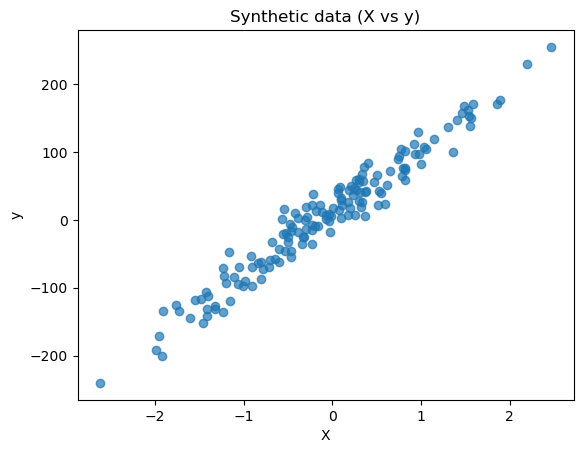

In [4]:

# Quick check / visualize
plt.scatter(X, y, alpha=0.7)
plt.title("Synthetic data (X vs y)")
plt.xlabel("X")
plt.ylabel("y")
plt.show()


In [5]:
# Step 2: Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


SKLearn LinearRegression -> slope (m): 91.96056047898979  intercept (b): 12.760908950722744
SKLearn Test RMSE: 18.423959638398884  R2: 0.9395273889475665


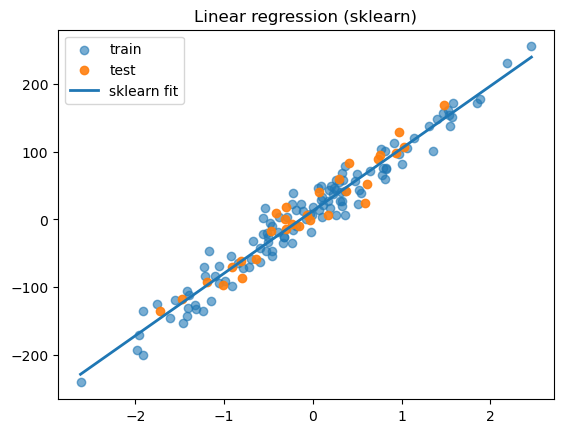

In [6]:

# ----------------------
# Method A: scikit-learn
# ----------------------
model = LinearRegression()
model.fit(X_train, y_train)   # fits intercept by default

# Get parameters
slope = model.coef_[0]
intercept = model.intercept_
print("SKLearn LinearRegression -> slope (m):", slope, " intercept (b):", intercept)

# Predictions and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("SKLearn Test RMSE:", rmse, " R2:", r2)

# Plot line on full data
X_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_line = model.predict(X_line)
plt.scatter(X_train, y_train, label="train", alpha=0.6)
plt.scatter(X_test, y_test, label="test", alpha=0.9)
plt.plot(X_line, y_line, label="sklearn fit", linewidth=2)
plt.legend()
plt.title("Linear regression (sklearn)")
plt.show()

In [7]:

# ---------------------------------
# Method B: closed-form (normal eq)
# ---------------------------------
# Build design matrix with intercept column of ones
X_b = np.c_[np.ones((X.shape[0], 1)), X]   # shape (n_samples, 2)
y_col = y.reshape(-1, 1)                   # shape (n_samples, 1)

# theta_best = (X^T X)^{-1} X^T y  (use pseudo-inverse for stability)
theta_best = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_col)
print("Normal equation theta (intercept, slope):", theta_best.ravel())

# Predictions using theta
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]
y_pred_ne = X_test_b.dot(theta_best).ravel()
print("Normal eq Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ne)),
      " R2:", r2_score(y_test, y_pred_ne))



Normal equation theta (intercept, slope): [13.51452103 92.21432069]
Normal eq Test RMSE: 18.277886165180544  R2: 0.9404824959642499


In [8]:
# ---------------------------------
# Method C: batch gradient descent
# ---------------------------------
def gradient_descent(X_design, y_vec, lr=0.01, n_iters=1000):
    n_samples, n_features = X_design.shape
    theta = np.zeros((n_features, 1))
    y = y_vec.reshape(-1, 1)
    cost_history = []

    for i in range(n_iters):
        predictions = X_design.dot(theta)               # shape (n_samples,1)
        errors = predictions - y
        gradients = (2 / n_samples) * X_design.T.dot(errors)
        theta -= lr * gradients
        cost = (1 / n_samples) * np.sum(errors ** 2)
        cost_history.append(cost)

    return theta, cost_history


Gradient descent theta: [13.51452103 92.21432069]


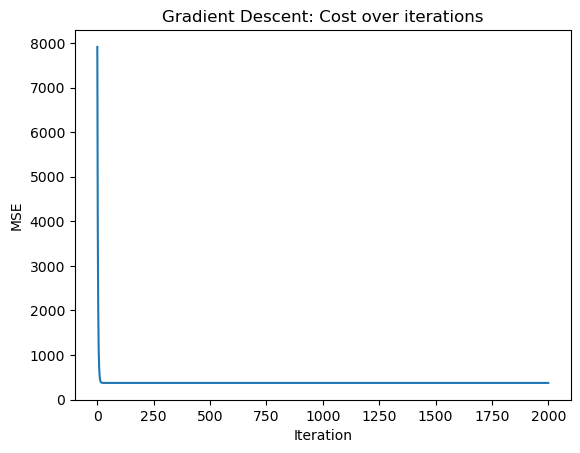

In [9]:

# Use the full X_b and y_col to train
theta_gd, cost_hist = gradient_descent(X_b, y_col, lr=0.1, n_iters=2000)
print("Gradient descent theta:", theta_gd.ravel())

# Plot cost history
plt.plot(cost_hist)
plt.title("Gradient Descent: Cost over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()


In [10]:

# GD predictions on test
y_pred_gd = X_test_b.dot(theta_gd).ravel()
print("Gradient Descent Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gd)),
      " R2:", r2_score(y_test, y_pred_gd))


# ---------------------------------
# Extra: polynomial features (non-linear relationship)
# ---------------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)  # adds X^2 term
X_poly = poly.fit_transform(X)  # shape (n_samples, 2)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_poly_train)
y_poly_pred = poly_model.predict(X_poly_test)
print("Polynomial (deg2) Test RMSE:", np.sqrt(mean_squared_error(y_poly_test, y_poly_pred)),
      " R2:", r2_score(y_poly_test, y_poly_pred))



Gradient Descent Test RMSE: 18.277886165180547  R2: 0.9404824959642499
Polynomial (deg2) Test RMSE: 18.438587959477804  R2: 0.9394313223069177


In [11]:

# ---------------------------------
# Extra: cross-validation baseline
# ---------------------------------
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("5-fold CV RMSE (sklearn linreg):", cv_rmse, " mean:", cv_rmse.mean())


# Summary prints
print("\nSummary of model params:")
print(" sklearn slope, intercept:", slope, intercept)
print(" normal eq theta:", theta_best.ravel())
print(" gradient descent theta:", theta_gd.ravel())


5-fold CV RMSE (sklearn linreg): [15.73112281 20.06632823 21.82825342 16.77147934 22.19832578]  mean: 19.31910191540835

Summary of model params:
 sklearn slope, intercept: 91.96056047898979 12.760908950722744
 normal eq theta: [13.51452103 92.21432069]
 gradient descent theta: [13.51452103 92.21432069]
